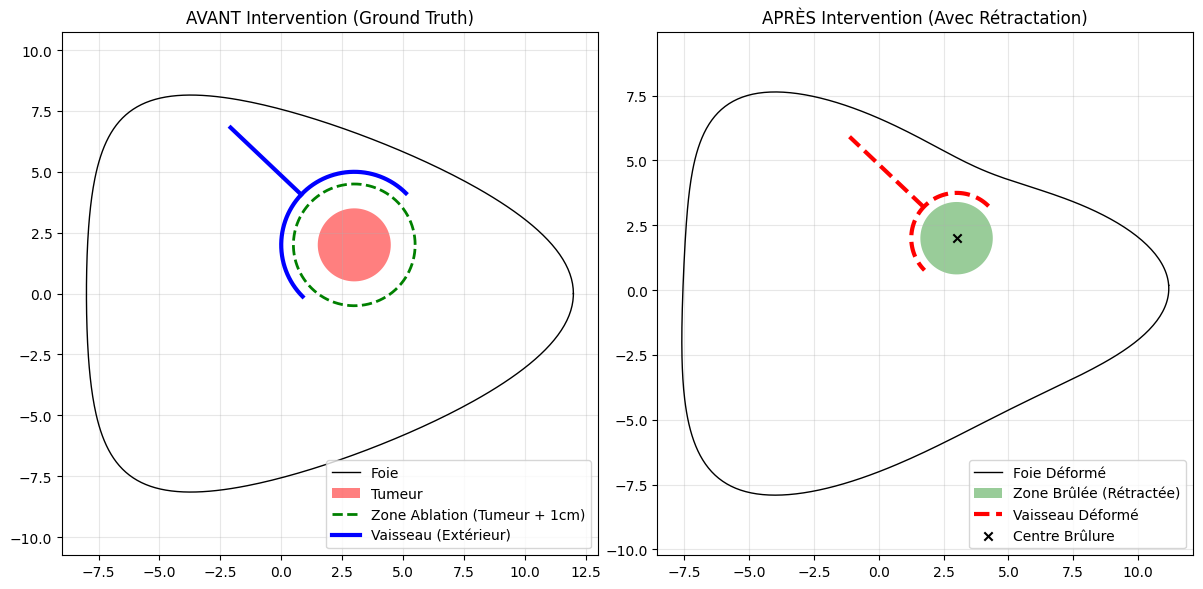

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. TA FONCTION DE PHYSIQUE (Imposée) ---
def apply_retraction(points, center, strength=0.4, radius_influence=4.0):
    """
    Simule la contraction des tissus vers un centre (brûlure).
    """
    vectors = points - center
    distances = np.linalg.norm(vectors, axis=1)
    
    # Sécurité division par zéro
    distances[distances == 0] = 0.001
    normalized_vectors = vectors / distances[:, None]
    
    # Formule Gaussienne inversée
    displacement_magnitude = strength * distances * np.exp(- (distances**2) / (2 * radius_influence**2))
    
    # Déplacement VERS le centre
    new_points = points - (normalized_vectors * displacement_magnitude[:, None])
    return new_points

# --- 2. GÉNÉRATEURS DE FORMES ---
def get_liver_shape(n_points=400):
    t = np.linspace(0, 2*np.pi, n_points)
    # Forme "Haricot"
    x = 10 * (np.cos(t) + 0.2 * np.cos(2*t))
    y = 8 * (np.sin(t) - 0.1 * np.sin(2*t))
    return np.column_stack((x, y))

def get_circle(center, radius, n_points=100):
    t = np.linspace(0, 2*np.pi, n_points)
    x = center[0] + radius * np.cos(t)
    y = center[1] + radius * np.sin(t)
    return np.column_stack((x, y))

def get_arc_vessel_with_branch(center_ablation, radius_vessel, start_angle, end_angle, branch_length=3.0):
    """
    Crée un vaisseau principal en arc de cercle autour de l'ablation
    + une branche qui part vers l'extérieur.
    """
    # 1. L'Arc Principal
    t = np.linspace(np.radians(start_angle), np.radians(end_angle), 60)
    arc_x = center_ablation[0] + radius_vessel * np.cos(t)
    arc_y = center_ablation[1] + radius_vessel * np.sin(t)
    arc = np.column_stack((arc_x, arc_y))
    
    # 2. La Branche (Bifurcation)
    # On la fait partir du milieu de l'arc
    mid_index = len(arc) // 2
    start_branch = arc[mid_index]
    
    # Direction : radiale vers l'extérieur (pour s'éloigner de la tumeur)
    # On calcule le vecteur normal au cercle à cet endroit
    vec_dir = start_branch - center_ablation
    vec_dir = vec_dir / np.linalg.norm(vec_dir)
    
    end_branch = start_branch + vec_dir * branch_length
    
    # On crée une ligne pour la branche
    branch_t = np.linspace(0, 1, 30)
    branch_x = (1-branch_t)*start_branch[0] + branch_t*end_branch[0]
    branch_y = (1-branch_t)*start_branch[1] + branch_t*end_branch[1]
    branch = np.column_stack((branch_x, branch_y))
    
    return arc, branch

# --- 3. PARAMÉTRAGE DE LA SCÈNE ---
centre_tumeur = np.array([3.0, 2.0])
rayon_tumeur = 1.5
marge = 1.0  # 1 cm
rayon_ablation = rayon_tumeur + marge

# Paramètres de la rétractation
FORCE_RETRACTATION = 0.5  # Assez fort pour être visible
RAYON_INFLUENCE = 5.0     # Assez large pour toucher les vaisseaux

# --- 4. CRÉATION DU MONDE "AVANT" (PRE-OP) ---

# A. Le Foie
foie_pre = get_liver_shape()

# B. La Tumeur
tumeur_pre = get_circle(centre_tumeur, rayon_tumeur)

# C. La Zone d'Ablation (Cible théorique)
zone_ablation_pre = get_circle(centre_tumeur, rayon_ablation)

# D. Le Vaisseau (Arc + Branche)
# Il doit être à l'extérieur de la zone d'ablation.
# Rayon ablation = 2.5 -> On met le vaisseau à 3.0 (0.5cm de sécurité)
rayon_vaisseau = rayon_ablation + 0.5 
arc_pre, branch_pre = get_arc_vessel_with_branch(
    centre_tumeur, 
    radius_vessel=rayon_vaisseau, 
    start_angle=45,  # Commence en haut à droite
    end_angle=225,   # Finit en bas à gauche (contourne par le haut/gauche)
    branch_length=4.0
)
vaisseaux_pre = [arc_pre, branch_pre]


# --- 5. SIMULATION DE L'INTERVENTION (POST-OP) ---

# On applique ta fonction apply_retraction à TOUT le monde
foie_post = apply_retraction(foie_pre, centre_tumeur, strength=FORCE_RETRACTATION, radius_influence=RAYON_INFLUENCE)

# Note: La tumeur n'existe plus physiquement, mais on calcule la déformation de l'espace
# La zone d'ablation visible est la version rétractée de la zone théorique
zone_ablation_post = apply_retraction(zone_ablation_pre, centre_tumeur, strength=FORCE_RETRACTATION, radius_influence=RAYON_INFLUENCE)

vaisseaux_post = []
for segment in vaisseaux_pre:
    seg_post = apply_retraction(segment, centre_tumeur, strength=FORCE_RETRACTATION, radius_influence=RAYON_INFLUENCE)
    vaisseaux_post.append(seg_post)


# --- 6. VISUALISATION ---
plt.figure(figsize=(12, 6))

# GAUCHE : AVANT
plt.subplot(1, 2, 1)
plt.title("AVANT Intervention (Ground Truth)")
plt.plot(foie_pre[:,0], foie_pre[:,1], 'k-', lw=1, label='Foie')
plt.fill(tumeur_pre[:,0], tumeur_pre[:,1], 'r', alpha=0.5, label='Tumeur')
# Zone ablation théorique en pointillés
plt.plot(zone_ablation_pre[:,0], zone_ablation_pre[:,1], 'g--', lw=2, label='Zone Ablation (Tumeur + 1cm)')

# Vaisseaux
for i, v in enumerate(vaisseaux_pre):
    label = "Vaisseau (Extérieur)" if i == 0 else ""
    plt.plot(v[:,0], v[:,1], 'b-', lw=3, label=label)

plt.axis('equal')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# DROITE : APRÈS
plt.subplot(1, 2, 2)
plt.title("APRÈS Intervention (Avec Rétractation)")
plt.plot(foie_post[:,0], foie_post[:,1], 'k-', lw=1, label='Foie Déformé')

# La zone d'ablation visible (réelle) est la verte pleine
plt.fill(zone_ablation_post[:,0], zone_ablation_post[:,1], 'g', alpha=0.4, label='Zone Brûlée (Rétractée)')

# Vaisseaux déformés
for i, v in enumerate(vaisseaux_post):
    label = "Vaisseau Déformé" if i == 0 else ""
    plt.plot(v[:,0], v[:,1], 'r--', lw=3, label=label)

# On affiche le centre pour repère
plt.scatter(centre_tumeur[0], centre_tumeur[1], c='k', marker='x', label="Centre Brûlure")

plt.axis('equal')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
import pyvista as pv
import numpy as np

# --- 1. FONCTION UTILITAIRE : NUMPY 2D -> VTK POLYDATA 3D ---
def curve_to_polydata(points_2d, is_closed=False):
    """
    Convertit une liste de points 2D (x, y) en un objet PyVista PolyData (x, y, z=0).
    is_closed=True -> Relie le dernier point au premier (pour le Foie/Ablation)
    is_closed=False -> Laisse ouvert (pour les Vaisseaux)
    """
    n_points = len(points_2d)
    
    # 1. Ajouter la dimension Z=0
    points_3d = np.column_stack((points_2d, np.zeros(n_points)))
    
    # 2. Créer la connectivité (Lignes)
    # Pour PyVista, une ligne se définit par : [Nombre_de_points, idx0, idx1, idx2...]
    if is_closed:
        # On ferme la boucle : 0->1->...->N->0
        # On crée une seule cellule qui contient tous les points
        cells = np.r_[n_points, np.arange(n_points)]
        # Note : PyVista comprend qu'il faut fermer si on utilise 'lines' correctement ou via constructeur
        # Méthode explicite ligne par ligne pour compatibilité maximale :
        lines = np.column_stack((
            np.full(n_points, 2),       # Chaque segment a 2 points
            np.arange(n_points),        # Point A
            np.roll(np.arange(n_points), -1) # Point B (le dernier se lie au premier)
        )).ravel()
    else:
        # Ligne ouverte : 0->1->...->N
        # On relie i à i+1
        lines = np.column_stack((
            np.full(n_points - 1, 2),
            np.arange(n_points - 1),
            np.arange(1, n_points)
        )).ravel()

    # 3. Création de l'objet PolyData
    mesh = pv.PolyData(points_3d)
    mesh.lines = lines
    return mesh

def merge_vessels(list_of_vessel_arrays):
    """Fusionne une liste de vaisseaux (tableaux numpy) en un seul Mesh PolyData"""
    combined_mesh = pv.PolyData()
    for v_points in list_of_vessel_arrays:
        v_mesh = curve_to_polydata(v_points, is_closed=False)
        combined_mesh += v_mesh # Fusion VTK automatique
    return combined_mesh

# --- 2. CRÉATION DES COMPOSANTS DE BASE ---
# On utilise les variables générées dans l'étape précédente :
# foie_pre, foie_post, vaisseaux_pre, vaisseaux_post, zone_ablation_pre, zone_ablation_post

# -- PRE-OP --
mesh_foie_pre = curve_to_polydata(foie_pre, is_closed=True)
mesh_vaisseaux_pre = merge_vessels(vaisseaux_pre)
mesh_ablation_pre = curve_to_polydata(zone_ablation_pre, is_closed=True)

# -- POST-OP --
mesh_foie_post = curve_to_polydata(foie_post, is_closed=True)
mesh_vaisseaux_post = merge_vessels(vaisseaux_post)
mesh_ablation_post = curve_to_polydata(zone_ablation_post, is_closed=True)


# --- 3. ASSEMBLAGE DES 4 STRUCTURES DEMANDÉES ---

# Structure 1 : Registration SOURCE (Pre-Op : Foie + Vaisseaux)
structure_1_pre_reg = mesh_foie_pre + mesh_vaisseaux_pre

# Structure 2 : Registration TARGET (Post-Op : Foie + Vaisseaux)
structure_2_post_reg = mesh_foie_post + mesh_vaisseaux_post

# Structure 3 : Validation SOURCE (Pre-Op : Foie + Vaisseaux + Ablation)
# Celle-ci sert de "Vérité Terrain" complète
structure_3_pre_full = mesh_foie_pre + mesh_vaisseaux_pre + mesh_ablation_pre

# Structure 4 : Validation TARGET (Post-Op : Foie + Vaisseaux + Ablation)
# Celle-ci sert à vérifier visuellement la rétractation avant correction
structure_4_post_full = mesh_foie_post + mesh_vaisseaux_post + mesh_ablation_post

In [13]:
import pyvista as pv

def visualiser_structures(s1, s2, s3, s4):
    """
    Affiche les 4 structures PolyData dans une grille 2x2.
    """
    # Création du plotter avec une grille 2x2
    pl = pv.Plotter(shape=(2, 2), window_size=(1200, 900))

    # --- HAUT-GAUCHE : Structure 1 (Pour le Recalage - Source) ---
    pl.subplot(0, 0)
    pl.add_text("1. REGISTRATION SOURCE (Pre-Op)\nContenu: Foie + Vaisseaux", font_size=10)
    # On affiche en bleu (code couleur classique pour le "Fixed/Source")
    pl.add_mesh(s1, color="royalblue", line_width=3, label="Structure 1")
    pl.view_xy()  # Vue de dessus 2D
    pl.add_axes()

    # --- HAUT-DROITE : Structure 2 (Pour le Recalage - Cible) ---
    pl.subplot(0, 1)
    pl.add_text("2. REGISTRATION TARGET (Post-Op)\nContenu: Foie + Vaisseaux (Déformés)", font_size=10)
    # On affiche en rouge (code couleur classique pour le "Moving/Target")
    pl.add_mesh(s2, color="firebrick", line_width=3, label="Structure 2")
    pl.view_xy()

    # --- BAS-GAUCHE : Structure 3 (Pour la Validation - Vérité Terrain) ---
    pl.subplot(1, 0)
    pl.add_text("3. VALIDATION GROUND TRUTH (Pre-Op)\nContenu: Foie + Vaisseaux + Zone Ablation Cible", font_size=10)
    # On affiche en bleu clair/cyan pour distinguer
    pl.add_mesh(s3, color="cornflowerblue", line_width=3, label="Structure 3")
    pl.view_xy()

    # --- BAS-DROITE : Structure 4 (Pour la Validation - Réalité Observable) ---
    pl.subplot(1, 1)
    pl.add_text("4. VALIDATION OBSERVÉE (Post-Op)\nContenu: Foie + Vaisseaux + Zone Ablation Visible", font_size=10)
    # On affiche en orange/rouge clair
    pl.add_mesh(s4, color="salmon", line_width=3, label="Structure 4")
    pl.view_xy()

    # Lier les vues : Zoomer sur l'un zoome sur tous
    pl.link_views()
    
    # Affichage final
    pl.show()

# --- APPEL DE LA FONCTION ---
# Assurez-vous d'avoir exécuté le bloc précédent pour créer les structures
visualiser_structures(
    structure_1_pre_reg, 
    structure_2_post_reg, 
    structure_3_pre_full, 
    structure_4_post_full
)

Widget(value='<iframe src="http://localhost:64081/index.html?ui=P_0x1606c7bf0_2&reconnect=auto" class="pyvista…

In [16]:
import os
os.environ["JAXTYPING_DISABLE"] = "1"
import torch
import skshapes as sks
import pyvista as pv
import numpy as np

# 1. CHARGEMENT
source = sks.PolyData(structure_1_pre_reg)
target = sks.PolyData(structure_2_post_reg)

# =========================================================
# 2. DEFINITION DE LA GRILLE FINE (REFINE)
# =========================================================

# N=25 : On passe d'une grille grossière (10x10) à une grille fine (~25x25)
# offset=0.2 : On serre la grille au maximum autour de l'objet (marge minuscule)
source.control_points = source.bounding_grid(N=25, offset=0.2)

# =========================================================
# 3. MODÈLE ADAPTÉ (Fine Scale)
# =========================================================

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    # IMPORTANT : Comme les points sont plus rapprochés, on réduit le scale.
    # Scale doit être environ 1.5x à 2x l'écartement des points de la grille.
    scale=1.5, 
    control_points=True
)

loss = sks.OptimalTransportLoss()

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=40, # On augmente un peu les itérations car il y a plus de paramètres à régler
    verbose=True,
    regularization_weight=0.001 
)

print(f"Nombre de points de contrôle : {source.control_points.n_points}")
print("Début du recalage Haute Définition...")
morphed = registration.fit_transform(source=source, target=target)
print("Terminé !")

# =========================================================
# 4. VISUALISATION ZOOMÉE
# =========================================================
source_color = "teal"
target_color = "red"

plotter = pv.Plotter(shape=(1, 2), window_size=(1200, 600))

# --- GAUCHE : AVANT ---
plotter.subplot(0, 0)
plotter.add_text("1. Grille FINE (Avant)", font_size=10, color="black")

# Affichage de la grille en fil de fer très fin
if hasattr(source, "control_points"):
    plotter.add_mesh(source.control_points.to_pyvista(), color="black", 
                     style="wireframe", line_width=1, opacity=0.4, label="Grille HD")
    # Points discrets pour voir la densité
    plotter.add_mesh(source.control_points.to_pyvista(), color="black", 
                     style="points", point_size=4)

plotter.add_mesh(source.to_pyvista(), color=source_color, opacity=0.6, line_width=2)
plotter.add_mesh(target.to_pyvista(), color=target_color, style="wireframe", line_width=2)
plotter.view_xy()

# --- DROITE : APRÈS ---
plotter.subplot(0, 1)
plotter.add_text(f"2. Résultat (Scale={model.scale})", font_size=10, color="black")

if hasattr(morphed, "control_points"):
    # On voit bien comment la grille fine s'est tordue localement
    plotter.add_mesh(morphed.control_points.to_pyvista(), color="black", 
                     style="wireframe", line_width=1, opacity=0.3)

plotter.add_mesh(morphed.to_pyvista(), color=source_color, opacity=0.7, line_width=3, label="Recalé")
plotter.add_mesh(target.to_pyvista(), color=target_color, style="wireframe", line_width=2, label="Cible")
plotter.add_legend()
plotter.view_xy()

plotter.link_views()
plotter.show()

Nombre de points de contrôle : 625
Début du recalage Haute Définition...
Initial loss : 3.81e-01
  = 3.81e-01 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 7.84e-03
  = 5.58e-04 + 0.001 * 7.28e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 7.54e-03
  = 4.87e-04 + 0.001 * 7.06e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 7.52e-03
  = 4.74e-04 + 0.001 * 7.05e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 7.52e-03
  = 4.74e-04 + 0.001 * 7.05e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 7.52e-03
  = 4.74e-04 + 0.001 * 7.05e+00 (fidelity + regularization_weight * regularization)
Loss after 6 iteration(s) : 7.52e-03
  = 4.74e-04 + 0.001 * 7.05e+00 (fidelity + regularization_weight * regularization)
Loss after 7 iteration(s) : 7.52e-03
  = 4.74e-04 + 0.001 * 7.05e+00 (fidelity + regularizati

Widget(value='<iframe src="http://localhost:64081/index.html?ui=P_0x33c2cb4a0_5&reconnect=auto" class="pyvista…

In [24]:
import os
os.environ["JAXTYPING_DISABLE"] = "1"
import torch
import skshapes as sks
import pyvista as pv
import numpy as np

# =========================================================
# 1. INVERSION DES RÔLES (Post -> Pre)
# =========================================================
# SOURCE : C'est le Post-Op (ce qui est déformé/rétracté)
# On utilise la structure 2 (Foie + Vaisseaux Post-Op) pour guider le recalage
source = sks.PolyData(structure_2_post_reg)

# CIBLE : C'est le Pre-Op (la vérité terrain que l'on veut retrouver)
target = sks.PolyData(structure_1_pre_reg)

# =========================================================
# 2. PARAMÈTRES (Grille Fine)
# =========================================================
# On construit la grille autour du Post-Op
source.control_points = source.bounding_grid(N=25, offset=0.2)

model = sks.ExtrinsicDeformation(
    n_steps=10,
    kernel="gaussian",
    scale=1.5,  # Scale fin pour capturer la courbure des vaisseaux
    control_points=True
)

loss = sks.OptimalTransportLoss()

registration = sks.Registration(
    model=model,
    loss=loss,
    optimizer=sks.LBFGS(),
    n_iter=40,
    verbose=True,
    regularization_weight=0.001 
)

print("--- DÉBUT DU RECALAGE INVERSE (Post -> Pre) ---")
# On déforme le Post-Op pour qu'il "gonfle" et revienne sur le Pre-Op
registration.fit(source=source, target=target)
print("--- RECALAGE TERMINÉ ---")

# =========================================================
# 3. LA VALIDATION CLINIQUE (CORRIGÉ FINAL)
# =========================================================

# 1. On charge la forme complète Post-Op
structure_validation_source = sks.PolyData(structure_4_post_full)

# 2. ON GREFFE LA GRILLE (Indispensable)
# On réutilise la grille qui a servi à calculer la déformation
structure_validation_source.control_points = source.control_points

print("Application de la déformation...")

# 3. MORPHING
# On utilise parameter_ et on récupère l'objet résultat
morphing_output = registration.model.morph(
    shape=structure_validation_source,
    parameter=registration.parameter_
)

# 4. EXTRACTION DE LA FORME
# C'est ici qu'on récupère le vrai objet PolyData
structure_finale = morphing_output.morphed_shape

print("✅ Déformation appliquée et forme extraite !")


# =========================================================
# 4. VISUALISATION DU RÉSULTAT
# =========================================================
pl = pv.Plotter(shape=(1, 2), window_size=(1400, 700))

# --- GAUCHE : SITUATION INITIALE ---
pl.subplot(0, 0)
pl.add_text("1. SITUATION POST-OP (Avant)", font_size=10)
pl.add_mesh(target.to_pyvista(), color="blue", style="wireframe", line_width=2, label="Planification (Pre-Op)")
pl.add_mesh(source.to_pyvista(), color="red", opacity=0.5, label="Réalité (Post-Op)")
pl.add_legend()
pl.view_xy()

# --- DROITE : VALIDATION DES MARGES ---
pl.subplot(0, 1)
pl.add_text("2. VALIDATION (De-Rétractation)", font_size=10)

# A. La Vérité Terrain (Pre-Op) : Cercle bleu fil de fer
pl.add_mesh(structure_3_pre_full, color="blue", style="wireframe", line_width=1, label="Vérité Terrain (Cible)")

# B. Le Résultat (Post-Op Recalé) : Forme pleine rouge
# On affiche la structure_finale qu'on vient d'extraire
pl.add_mesh(structure_finale.to_pyvista(), color="red", opacity=0.5, label="Zone Corrigée")

pl.add_legend()
pl.view_xy()
pl.link_views()
pl.show()

--- DÉBUT DU RECALAGE INVERSE (Post -> Pre) ---
Initial loss : 3.81e-01
  = 3.81e-01 + 0.001 * 0.00e+00 (fidelity + regularization_weight * regularization)
Loss after 1 iteration(s) : 7.95e-03
  = 7.77e-04 + 0.001 * 7.18e+00 (fidelity + regularization_weight * regularization)
Loss after 2 iteration(s) : 7.61e-03
  = 5.69e-04 + 0.001 * 7.04e+00 (fidelity + regularization_weight * regularization)
Loss after 3 iteration(s) : 7.61e-03
  = 5.80e-04 + 0.001 * 7.03e+00 (fidelity + regularization_weight * regularization)
Loss after 4 iteration(s) : 7.61e-03
  = 5.80e-04 + 0.001 * 7.03e+00 (fidelity + regularization_weight * regularization)
Loss after 5 iteration(s) : 7.61e-03
  = 5.80e-04 + 0.001 * 7.03e+00 (fidelity + regularization_weight * regularization)
Loss after 6 iteration(s) : 7.61e-03
  = 5.80e-04 + 0.001 * 7.03e+00 (fidelity + regularization_weight * regularization)
Loss after 7 iteration(s) : 7.61e-03
  = 5.80e-04 + 0.001 * 7.03e+00 (fidelity + regularization_weight * regularizatio

Widget(value='<iframe src="http://localhost:64081/index.html?ui=P_0x33643cbf0_7&reconnect=auto" class="pyvista…